<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/pyroVED_examples_C_cont_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditioning VAE on a continuous "property" vector

Prepared by Maxim Ziatdinov


---

This notebook denonstrates how to condition VAE on a *known* property (orproperties) of the data to help it discover the unknown ones. We demnstrate it using synthetic 1D spectral data with random variations in peak position and width.

---



E-mail: ziatdinovmax@gmail.com

Install pyroVED package:

In [1]:
!pip install git+https://github.com/ziatdinovmax/pyroved

  Cloning https://github.com/ziatdinovmax/pyroved to /tmp/pip-req-build-g_yddg2_
  Running command git clone -q https://github.com/ziatdinovmax/pyroved /tmp/pip-req-build-g_yddg2_
     |████████████████████████████████| 634kB 15.6MB/s 
  Created wheel for pyroved: filename=pyroved-0.2.3-cp37-none-any.whl size=46301 sha256=57f4ad56344e5d42e54fdfe56417ecaed571a2e379a465e0f4d6e07fd1cb43b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ad2mzal0/wheels/2d/11/95/d917fd32a13c6886b23783a3ac409d888b53a5389ae07d26d5
Successfully built pyroved


Imports:

In [2]:
import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt

First, we prepare our synthetic data representing 1D Gaussian signals with different widths that is randomly shifted along the *x*-axis and is corrupted by noise.

In [3]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

n_samples = 5000 # number of samples
l_signal = 100 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
torch.manual_seed(1)  # for reproducibility
x = torch.linspace(-12, 12, l_signal).expand(n_samples, l_signal)
noise = torch.randint(1, 100, (n_samples, 1)) / 1e3
mu = torch.randint(-30, 30, size=(n_samples, 1)) / 10
sig = torch.randint(50, 500, size=(n_samples, 1)) / 1e2
train_data = gaussian(x, mu, sig) + noise * torch.randn(size=(n_samples, l_signal))
# Normalize to (0, 1)
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

In [4]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), mu, batch_size=64)

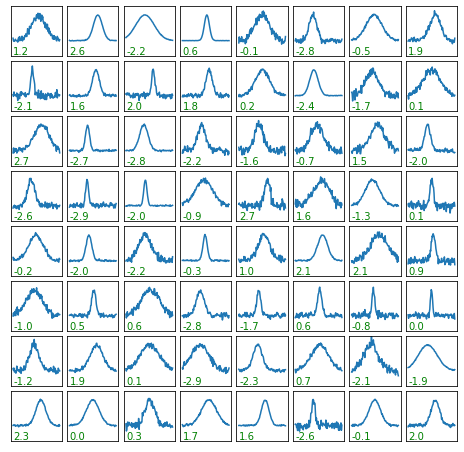

In [5]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y, m) in zip(axes.flat, train_loader):
    ax.plot(x[0], y[0, 0])
    ax.set_ylim(-0.15, 1.0)
    ax.text(0.05, 0.05, str(np.around(m[0].item(), decimals=4)),
            transform=ax.transAxes, color='green')

Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about shifts as our $c$ vector.

In [6]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 61.1289
Epoch: 2 Training loss: 59.8919
Epoch: 3 Training loss: 59.8143
Epoch: 4 Training loss: 59.6454
Epoch: 5 Training loss: 59.0023
Epoch: 6 Training loss: 58.8899
Epoch: 7 Training loss: 58.8430
Epoch: 8 Training loss: 58.8052
Epoch: 9 Training loss: 58.8105
Epoch: 10 Training loss: 58.8100
Epoch: 11 Training loss: 58.7720
Epoch: 12 Training loss: 58.7680
Epoch: 13 Training loss: 58.7616
Epoch: 14 Training loss: 58.7508
Epoch: 15 Training loss: 58.7523
Epoch: 16 Training loss: 58.7396
Epoch: 17 Training loss: 58.7439
Epoch: 18 Training loss: 58.7386
Epoch: 19 Training loss: 58.7352
Epoch: 20 Training loss: 58.7352
Epoch: 21 Training loss: 58.7172
Epoch: 22 Training loss: 58.7212
Epoch: 23 Training loss: 58.7244
Epoch: 24 Training loss: 58.7125
Epoch: 25 Training loss: 58.7321
Epoch: 26 Training loss: 58.7284
Epoch: 27 Training loss: 58.7181
Epoch: 28 Training loss: 58.7085
Epoch: 29 Training loss: 58.7266
Epoch: 30 Training loss: 58.7146
Epoch: 31 Training 

Encode the training data into the latent space:

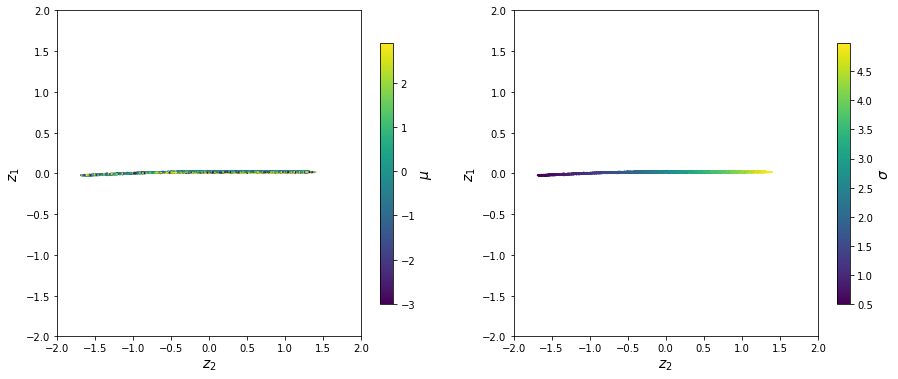

In [7]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig)
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

Our data had only two factors of variation, peak position and peak width. By conditioning the model on the "known" property (shift) it was able to clearly identify the unknown one (width). Notice that [without the conditioning](https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/master/examples/shiftVAE.ipynb?authuser=1#scrollTo=B_jDOtumPm4C&line=8&uniqifier=1), the two factors of variation wouldn't be completely disentangled.

Plot the learned latent manifolds conditioned on the shift:

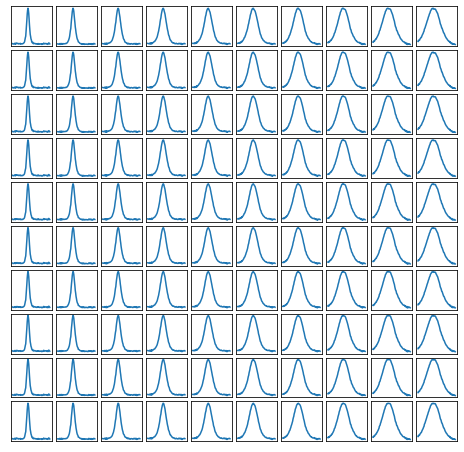

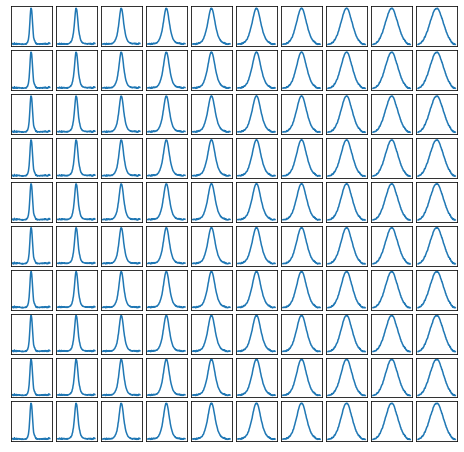

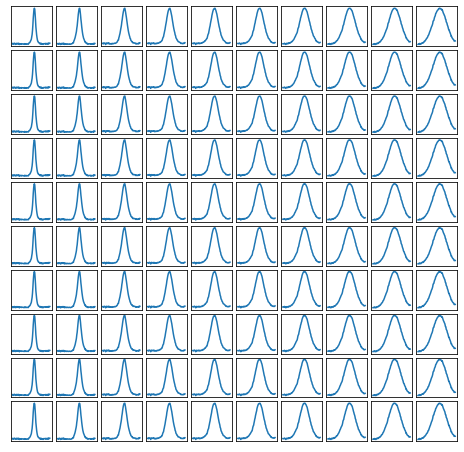

In [8]:
y_all = [-2, 0, 2]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    vae.manifold2d(10, y)

Plot the latent variables vs. the ground truth:

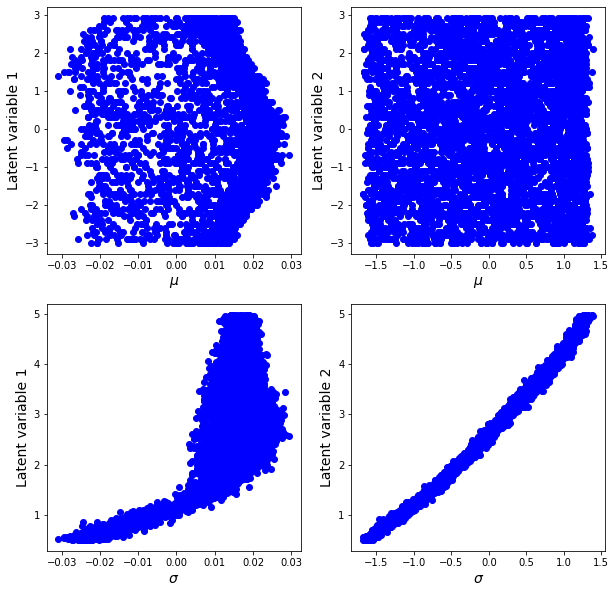

In [9]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(z_mean[:, 0], mu, c='blue')
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("Latent variable 1", fontsize=14)
ax[0, 1].scatter(z_mean[:, 1], mu, c='blue')
ax[0, 1].set_xlabel("$\mu$", fontsize=14)
ax[0, 1].set_ylabel("Latent variable 2", fontsize=14)
ax[1, 0].scatter(z_mean[:, 0], sig, c='blue')
ax[1, 0].set_xlabel("$\sigma$", fontsize=14)
ax[1, 0].set_ylabel("Latent variable 1", fontsize=14)
ax[1, 1].scatter(z_mean[:, 1], sig, c='blue')
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("Latent variable 2", fontsize=14);

Now let's condition on a 2-dimensional vector containing information on the peak shifts and widths.

In [10]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([mu, sig], -1), batch_size=64)

In [11]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
svae = pv.models.iVAE(in_dim, latent_dim=2, c_dim=2, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(svae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 60.0581
Epoch: 2 Training loss: 57.8816
Epoch: 3 Training loss: 57.6853
Epoch: 4 Training loss: 57.5942
Epoch: 5 Training loss: 57.5242
Epoch: 6 Training loss: 57.4824
Epoch: 7 Training loss: 57.4460
Epoch: 8 Training loss: 57.4231
Epoch: 9 Training loss: 57.4140
Epoch: 10 Training loss: 57.4059
Epoch: 11 Training loss: 57.3960
Epoch: 12 Training loss: 57.3891
Epoch: 13 Training loss: 57.3854
Epoch: 14 Training loss: 57.3818
Epoch: 15 Training loss: 57.3789
Epoch: 16 Training loss: 57.3753
Epoch: 17 Training loss: 57.3730
Epoch: 18 Training loss: 57.3719
Epoch: 19 Training loss: 57.3697
Epoch: 20 Training loss: 57.3681
Epoch: 21 Training loss: 57.3662
Epoch: 22 Training loss: 57.3664
Epoch: 23 Training loss: 57.3644
Epoch: 24 Training loss: 57.3618
Epoch: 25 Training loss: 57.3623
Epoch: 26 Training loss: 57.3616
Epoch: 27 Training loss: 57.3603
Epoch: 28 Training loss: 57.3603
Epoch: 29 Training loss: 57.3601
Epoch: 30 Training loss: 57.3592
Epoch: 31 Training 

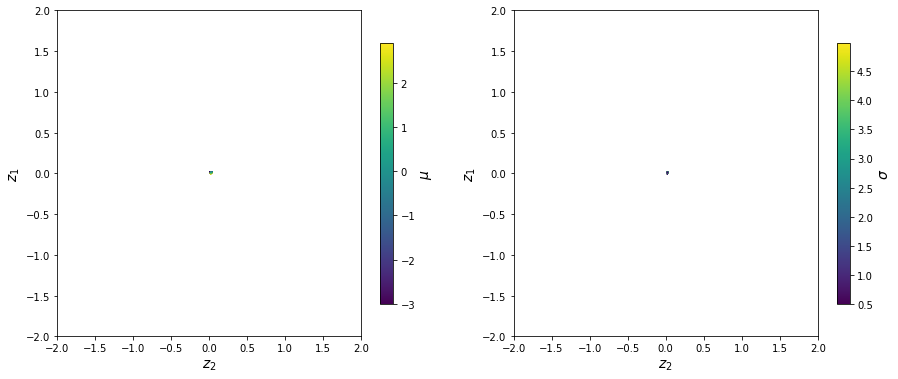

In [12]:
z_mean, z_sd = svae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig)
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

As expected, the latent space is collapsed (there are no factors of variation left to discover).